In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from monai.networks.nets import BasicUNet
import pytorch_lightning as pl

# 创建一个字典来保存中间层的特征图
feature_maps = {}

def hook_fn(module, input, output):
    # 将特征图保存在字典中
    feature_maps[module] = output


# 创建一个与训练时定义相同的模型类
class BasicUNetLightning(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = BasicUNet(
            spatial_dims=2,
            in_channels=1,
            out_channels=1,
            features=(32,32,64,128,256,32),
            dropout=0.50,
        )
    
    def forward(self, x):
        return self.model(x)

# 使用 load_from_checkpoint 加载检查点
checkpoint_path = "UNet_logs/UNet/version_33/UNet-epoch=111-val_dice=0.7980.ckpt"
model = BasicUNetLightning.load_from_checkpoint(checkpoint_path)
print(model)
model.model.conv_0.register_forward_hook(hook_fn)
model.model.upcat_4.register_forward_hook(hook_fn)
model.model.final_conv.register_forward_hook(hook_fn)

BasicUNet features: (32, 32, 64, 128, 256, 32).
BasicUNetLightning(
  (model): BasicUNet(
    (conv_0): TwoConv(
      (conv_0): Convolution(
        (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (adn): ADN(
          (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (D): Dropout(p=0.5, inplace=False)
          (A): LeakyReLU(negative_slope=0.1, inplace=True)
        )
      )
      (conv_1): Convolution(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (adn): ADN(
          (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (D): Dropout(p=0.5, inplace=False)
          (A): LeakyReLU(negative_slope=0.1, inplace=True)
        )
      )
    )
    (down_1): Down(
      (max_pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (convs): TwoConv(
        (conv_0): Convolution(
       

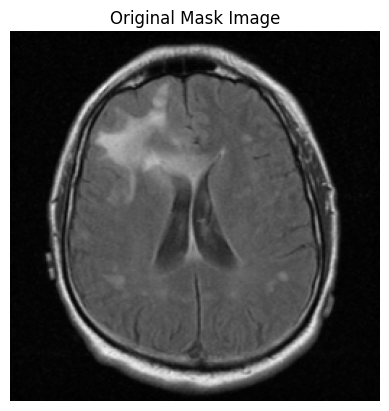

Mask Tensor Shape: torch.Size([1, 256, 256])


In [3]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 图像文件路径
mask_path = 'lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif'

# 加载图像
mask_image = Image.open(mask_path)

# 显示原始图像
plt.imshow(mask_image, cmap='gray')
plt.title("Original Mask Image")
plt.axis("off")
plt.show()

# 转换为 PyTorch Tensor
transform = transforms.ToTensor()
mask_tensor = transform(mask_image)

# 检查 Tensor 的大小
print("Mask Tensor Shape:", mask_tensor.shape)


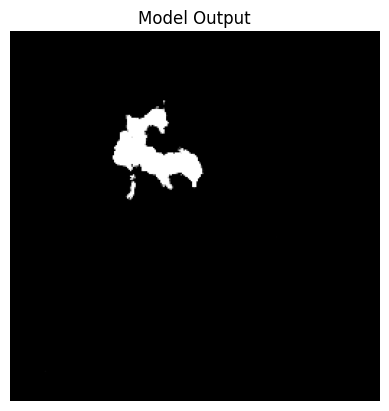

In [4]:
# 将 mask_tensor 添加批次维度并输入到模型中
mask_input = mask_tensor.unsqueeze(0)  # 添加批次维度，形状为 (1, 1, H, W)
output = torch.sigmoid(model(mask_input))  # 模型的输出

# 显示模型输出
output_image = output.squeeze().detach().numpy()  # 去除批次和通道维度
plt.imshow(output_image, cmap='gray')
plt.title("Model Output")
plt.axis("off")
plt.show()


In [5]:
for layer, fmap in feature_maps.items():
    print(f"Layer: {layer}, Feature Map Shape: {fmap.shape}\n")


Layer: TwoConv(
  (conv_0): Convolution(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (adn): ADN(
      (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (D): Dropout(p=0.5, inplace=False)
      (A): LeakyReLU(negative_slope=0.1, inplace=True)
    )
  )
  (conv_1): Convolution(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (adn): ADN(
      (N): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (D): Dropout(p=0.5, inplace=False)
      (A): LeakyReLU(negative_slope=0.1, inplace=True)
    )
  )
), Feature Map Shape: torch.Size([1, 32, 256, 256])

Layer: UpCat(
  (upsample): UpSample(
    (deconv): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  )
  (convs): TwoConv(
    (conv_0): Convolution(
      (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (adn): ADN(
        (N): InstanceNorm2d(

In [6]:
# 获取 TwoConv 层的特征图
two_conv_layer = list(feature_maps.keys())[1]
feature_map = feature_maps[two_conv_layer]
print("Feature Map Shape:", feature_map.shape)


Feature Map Shape: torch.Size([1, 128, 32, 32])


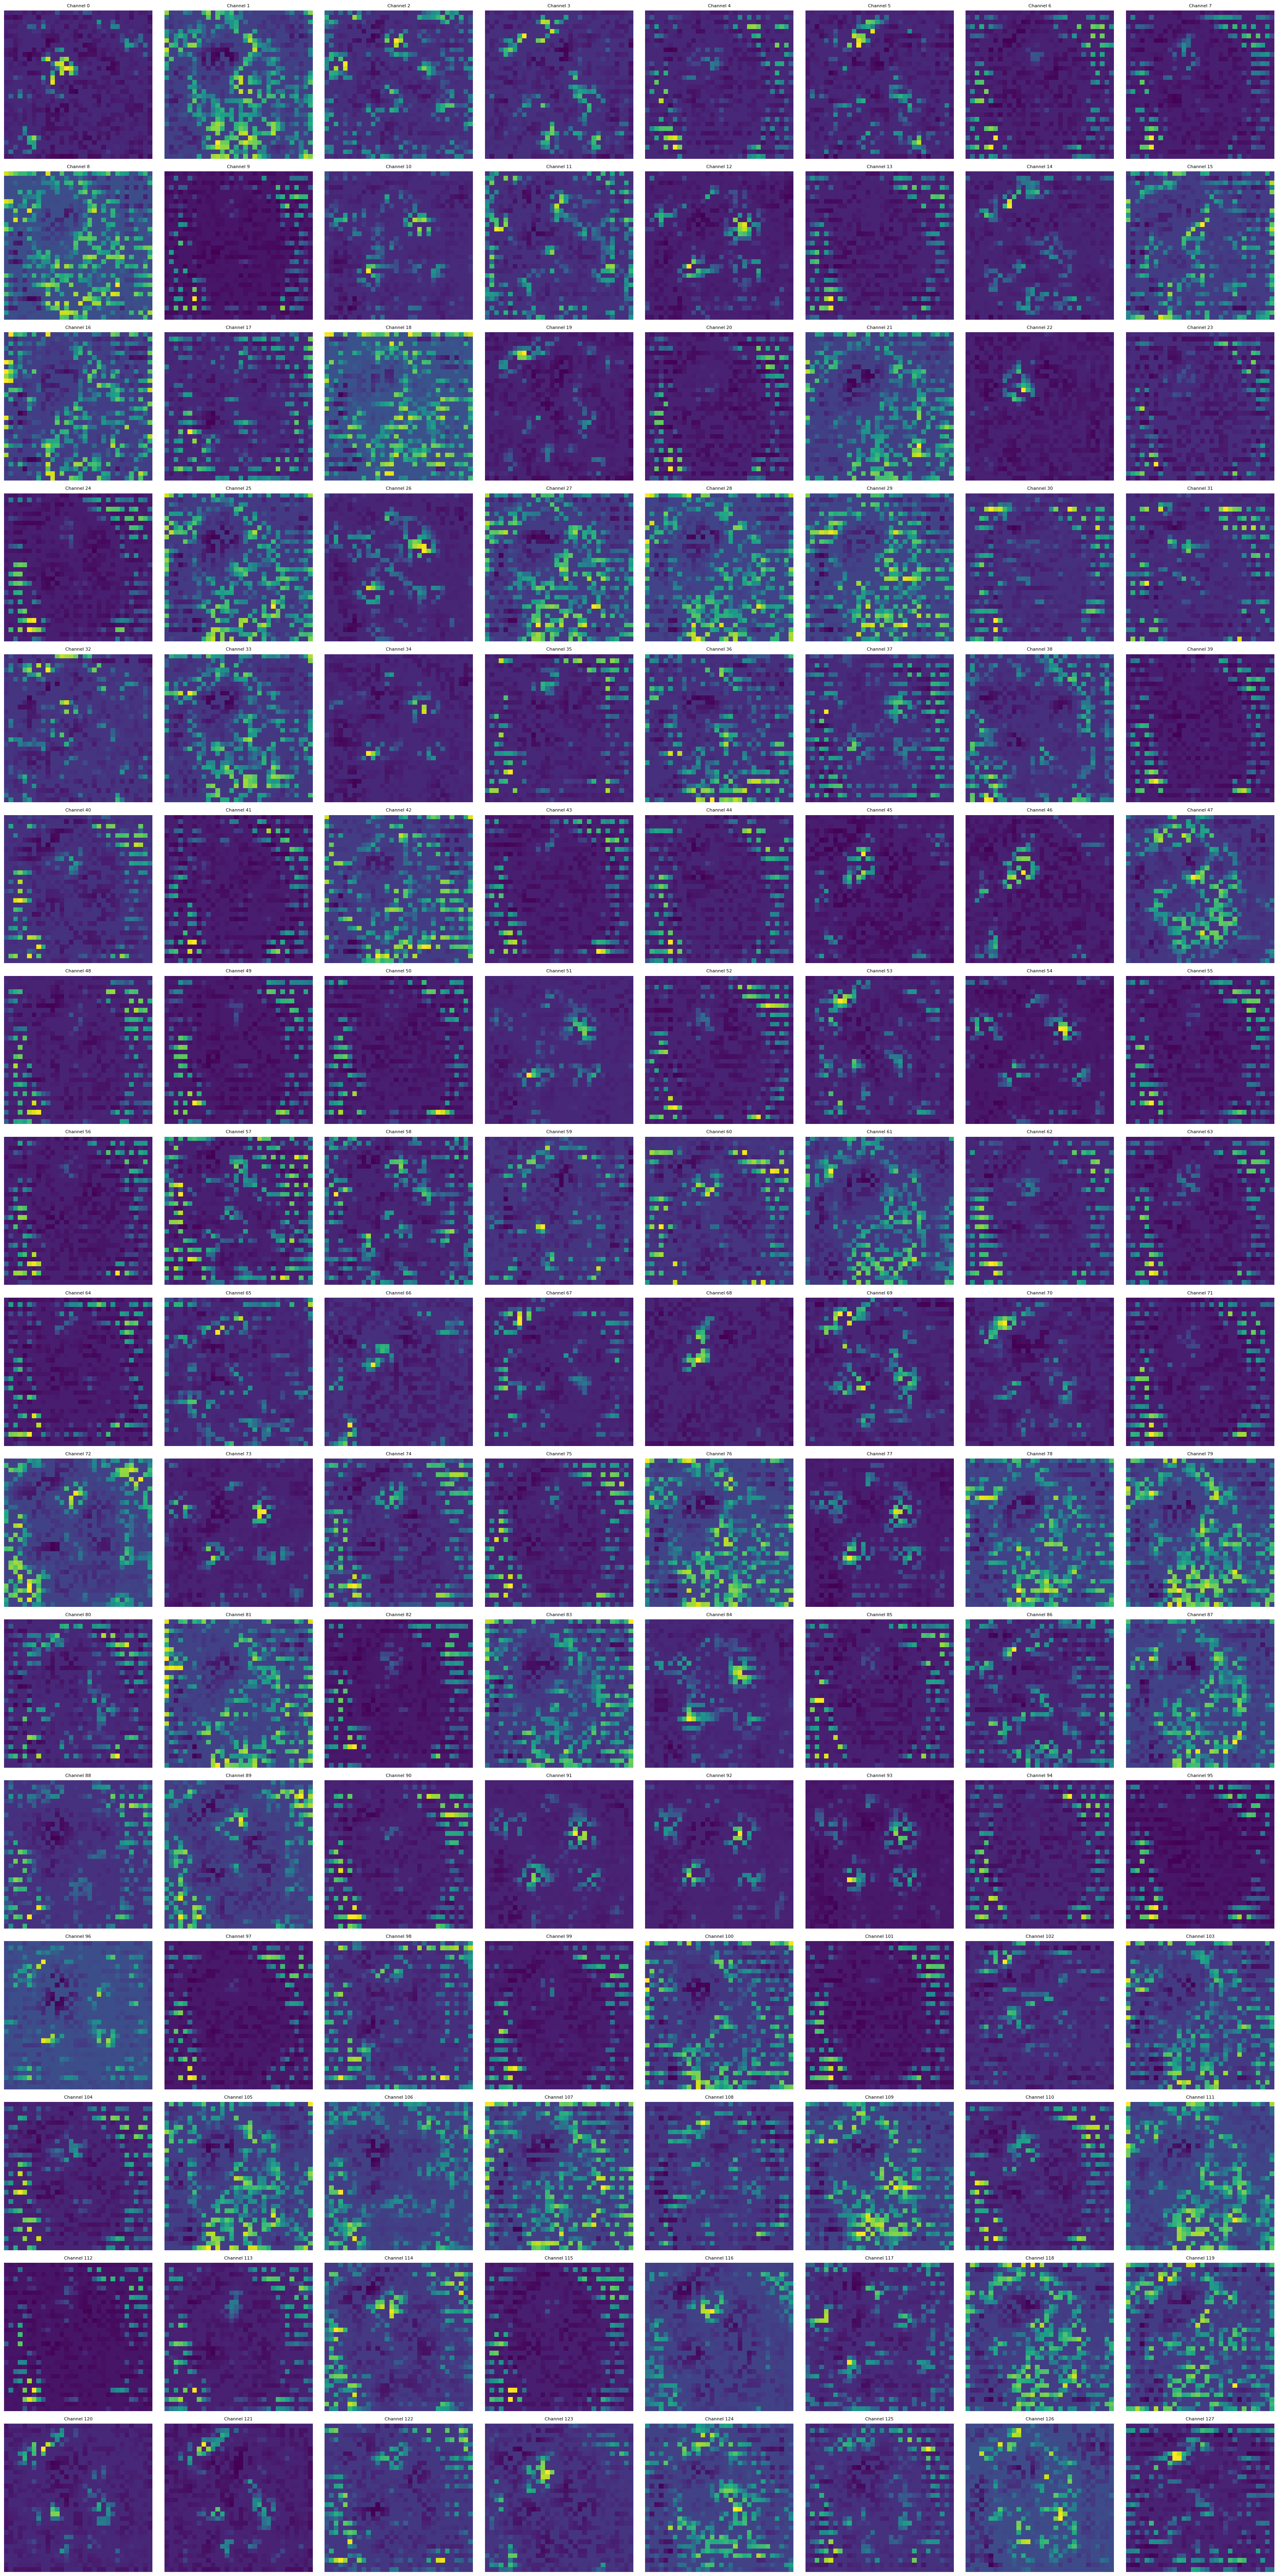

In [7]:
from UNethology.plot_tools import visualize_feature_map

visualize_feature_map(feature_map)